### Imports

In [1]:
import numpy as np
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
import torch.utils.data as data_utils
import wandb
from PIL import Image
import seaborn as sns
import sys
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amsfonts}'

sns.set(font='Franklin Gothic Book',
        rc={
            'text.usetex': True,
            'font.family': 'serif',
            'text.latex.preamble': [r'\usepackage{amsmath}', r'\usepackage{amsfonts}'],
            'axes.axisbelow': False,
            'axes.edgecolor': 'lightgrey',
            'axes.facecolor': 'None',
            'axes.grid': False,
            'axes.labelcolor': 'black',
            'axes.spines.right': False,
            'axes.spines.top': False,
            'figure.facecolor': 'white',
            'lines.solid_capstyle': 'round',
            'patch.edgecolor': 'w',
            'patch.force_edgecolor': True,
            'text.color': 'black',
            'xtick.bottom': False,
            'xtick.color': 'black',
            'xtick.direction': 'out',
            'xtick.top': False,
            'ytick.color': 'black',
            'ytick.direction': 'out',
            'ytick.left': False,
            'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":18,
                                "axes.labelsize":14})


In [3]:
M_darkpurple = '#783CBB'
M_lightpurple = '#A385DB'
# M_green = '#479C8A'
M_green = '#0a888a'
M_yellow = '#FFDD99'
M_lightpink = '#EFA9CD'
M_darkpink = '#E953AD'

colour_list = [M_lightpink, M_green, M_darkpurple, M_darkpink, M_lightpurple, M_yellow]
cd = {'lightpink': M_lightpink, 'lightpurple': M_lightpurple, 'green': M_green, 'purple': M_darkpurple, 'pink': M_darkpink, 'yellow': M_yellow}
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour_list)

### Helper functions

In [51]:
def load_trained_model(num_classes, model_path): 

    model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    # INCEPTION
    # # Define model architecture
    # model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
    # # Replace last layers with new layers
    # num_ftrs = model.fc.in_features
    # model.fc = nn.Sequential(
    #     nn.Linear(num_ftrs, 2048),
    #     nn.ReLU(inplace=True),
    #     nn.Dropout(p=0.7),
    #     nn.Linear(2048, num_classes),
    #     nn.Softmax(dim=1)
    # )

    # Load the saved model state dict
    model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    model.eval()

    return model

def test_model(model, test_loader, device):
    
    correct = 0
    total = 0
    
    # Create a progress bar
    progress_bar = tqdm(test_loader, desc='Testing', unit='batch')

    with torch.no_grad():
        true_labels = []
        predictions = []
        probabilities = []
        for inputs, labels in progress_bar:
            # move to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.extend(labels.tolist())

            # Forward pass
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update variables
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probabilities.extend(probs.tolist())
            predictions.extend(predicted.tolist())

            # Update progress bar description
            progress_bar.set_postfix({'Accuracy': '{:.2f}%'.format((correct / total) * 100)})
    
    # # Compute accuracy (testing for now) --delete
    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))
    # Close the progress bar
    progress_bar.close()
    
    return true_labels, probabilities, predictions

def roc_plot(y_test, model_probabilities):
    # keep probabilities for the positive outcome only
    # predicted_probs = [model_probabilities[i][1] for i in range(len(model_probabilities))]
    # calculate scores
    auc_score = roc_auc_score(y_test, model_probabilities)
    # summarize scores
    print('ROC AUC=%.3f' % (auc_score))
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_test, model_probabilities)
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, color=cd['green'], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, color=cd['lightpurple'], marker='.', label='Perfect Model')
    # axis labels
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend()
    # plt.show()
    # plt.savefig("../data/roc.png")
    # plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + 'perfect_roc' + ".svg", format="svg", bbox_inches='tight')
    plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + "perfect_roc" + ".eps", format="eps", bbox_inches='tight')

def get_metrics(y_test, predictions):
    report = metrics.classification_report(y_test, predictions)
    return report

def plot_confusion_matrix(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='BuGn')
    plt.title('Confusion Matrix');
    plt.xlabel('\nPredicted Label')
    plt.ylabel('True Label')
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap='plasma', values_format='.0f')
    # disp.plot(cmap='PuBuGn', values_format='.2%')
    # plt.show()
    plt.savefig("../data/cm.png")
    
def plot_pr_curve(y_test, model_probabilities):
    # keep probabilities for the positive outcome only
    # predicted_probs = [model_probabilities[i][1] for i in range(len(model_probabilities))]
    precision, recall, thresholds = precision_recall_curve(y_test, model_probabilities)
    
    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color=cd['lightpurple'])
    
    no_skill = [0.5, 0.5]
    ax.plot([0, 1], no_skill, linestyle='--', label='No Skill', color=cd['green'])
    
    recall_vertical = [1, 1]
    precision_vertical = [0.5, 1]
    plt.plot(recall_vertical, precision_vertical, '-', label='Perfect Model', color=cd['lightpurple'])
    plt.plot([1, 1], '.', color=cd['lightpurple'])
    plt.plot([1, 0.5], '.', color=cd['lightpurple'])
    plt.plot([0, 1], '.', color=cd['lightpurple'])

    #add axis labels to plot
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.ylim([0.45, 1.05])
    plt.legend()

    #display plot
    # plt.show()
    # plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + 'perfect_pr' + ".svg", format="svg", bbox_inches='tight')
    plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + "perfect_pr" + ".eps", format="eps", bbox_inches='tight')
        

### Data helper functions

In [8]:
# Split image folders into train, val, test
def split_data(patch_directory, split: list, seed):
    '''
    Function that takes in the split percentage for train/val/test sets, and randomly chooses which cases
    to allocate to which set (to ensure all patches from one case go into one set)
    Parameters:
    patch_directory: folder containing all patches
    split: list of integers for splitting sets
    seed: option to set the seed value for randomness
    Returns:
    3 lists for each of train/val/test, where each list contains the case names to be used in the set
    '''
    
    random.seed(seed)

    case_folders = os.listdir(patch_directory) # get 147 case folders
    
    d = {}
    for folder in case_folders:
        num_patches_in_folder = len(os.listdir(patch_directory + folder))
        d[folder] = num_patches_in_folder
    
    total_num_patches = sum(d.values())
    train_split, val_split, test_split = split
    train_num_patches = int((train_split/100)*total_num_patches)
    val_num_patches = int((val_split/100)*total_num_patches)

    # list all folders in the directory
    folders = [os.path.join(patch_directory, folder) for folder in os.listdir(patch_directory) if os.path.isdir(os.path.join(patch_directory, folder))]
    
    # SELECT TRAINING CASES
    train_cases = [] # store all selected cases
    num_selected_train = 0 # number of patches selected so far
    selected_folders = set() # a set to store the selected folder names to keep track of those already selected
    while num_selected_train < train_num_patches:
        folder = random.choice(folders)
        if folder not in selected_folders:
            case = folder.replace(patch_directory, '')
            num_patches = len(os.listdir(folder))
            num_selected_train += num_patches
            selected_folders.add(folder) # add to set of selected folders
            train_cases.append(case)

    # SELECT VAL CASES
    val_cases = [] # store all selected cases
    num_selected_val = 0 # number of patches selected so far
    while num_selected_val < val_num_patches:
        folder = random.choice(folders)
        if folder not in selected_folders:
            case = folder.replace(patch_directory, '')
            num_patches = len(os.listdir(folder))
            num_selected_val += num_patches
            selected_folders.add(folder)
            val_cases.append(case)

    # SELECT TEST CASES
    cases = [folder.replace(patch_directory, '') for folder in folders]
    used = train_cases+val_cases
    test_cases = [case for case in cases if case not in used]
    
    # test_patches = [len(os.listdir(patch_directory + folder)) for folder in test_cases]
    num_selected_test = sum([len(os.listdir(patch_directory + folder)) for folder in test_cases])
    # dict = {x: for x in ['train', 'val', 'test']}
    print(f"Number of training patches: {num_selected_train} \nNumber of validation patches {num_selected_val} \nNumber of test patches {num_selected_test}")
    return train_cases, val_cases, test_cases

# Create a custom PyTorch dataset to read in your images and apply transforms

class CustomDataset(Dataset):
    def __init__(self, img_folders, label_files, transform=None):
        self.img_folders = img_folders
        self.label_files = label_files
        self.transform = transform

        self.imgs = [] # Keeps image paths to load in the __getitem__ method
        self.labels = []

        # Load images and corresponding labels
        for i, (img_folder, label_file) in enumerate(zip(img_folders, label_files)):
            # print("Patch directory", img_folder, "\nLabel file", label_file)
            labels_pt = torch.load(label_file) # Load .pt file
            # Run through all patches from the case folder
            for i, img in enumerate(os.listdir(img_folder)):
                if os.path.isfile(img_folder + '/' + img) and os.path.isfile(label_file):
                    # print(img_folder + img)
                    if img.startswith('._'):
                        img = img.replace('._', '')
                    idx = int(img.replace('.png', '').split("_")[1])
                    self.imgs.append(img_folder + '/' + img)
                    self.labels.append(labels_pt[idx].item()) # get label as int
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # Load image at given index
        image_path = self.imgs[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform is not None: # Apply transformations
            image = self.transform(image)
        
        label = self.labels[idx] # Load corresponding image label
        
        return image, label # Return transformed image and label
    
def load_data(INPUT_SIZE, SEED, batch_size, num_cpus):
    # DATALOADERS

    # Initialise data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test' : transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # using full set of data
    img_dir = '../data/patches/'
    labels_dir = '../data/labels/'
    # img_dir = '/Volumes/AlexS/MastersData/processed/patches/'
    # labels_dir = '/Volumes/AlexS/MastersData/processed/labels/'

    split=[70, 15, 15] # for splitting into train/val/test

    train_cases, val_cases, test_cases = split_data(img_dir, split, SEED)

    train_img_folders = [img_dir + case for case in train_cases]
    val_img_folders = [img_dir + case for case in val_cases]
    test_img_folders = [img_dir + case for case in test_cases]

    # Contains the file path for each .pt file for the cases used in each of the sets
    train_labels = [labels_dir + case + '.pt' for case in train_cases]
    val_labels = [labels_dir + case + '.pt' for case in val_cases]
    test_labels = [labels_dir + case + '.pt' for case in test_cases]

    image_datasets = {
        'train': CustomDataset(train_img_folders, train_labels, transform=data_transforms['train']),
        'val': CustomDataset(val_img_folders, val_labels, transform=data_transforms['val']),
        'test': CustomDataset(test_img_folders, test_labels, transform=data_transforms['test'])
    }
    # Create training, validation and test dataloaders
    dataloaders = {
        'train': data_utils.DataLoader(image_datasets['train'], batch_size=batch_size, num_workers=num_cpus, shuffle=True, drop_last=True),
        'val': data_utils.DataLoader(image_datasets['val'], batch_size=batch_size, num_workers=num_cpus, shuffle=True),
        'test': data_utils.DataLoader(image_datasets['test'], batch_size=batch_size, num_workers=num_cpus, shuffle=True)
    }

    return dataloaders

In [9]:
##### SET PARAMETERS #####
num_classes = 2
batch_size = 32
model_name = 'None'

PATCH_SIZE=256
STRIDE=PATCH_SIZE
SEED=42
num_cpus=8

if model_name == 'inception': 
    INPUT_SIZE=299 
else: INPUT_SIZE=PATCH_SIZE

# Load data
dataloaders = load_data(INPUT_SIZE, SEED, batch_size, num_cpus)

# Load model
model_path = '../models/splendid-dawn-22_model_weights.pth'
model = load_trained_model(num_classes, model_path)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model = model.to(device)

true_labels, model_probabilities, model_predictions = test_model(model, dataloaders['test'], device)

Number of training patches: 258108 
Number of validation patches 58768 
Number of test patches 47709


Testing: 100%|██████████| 746/746 [04:19<00:00,  2.88batch/s, Accuracy=73.14%]

Test Accuracy: 73.14%


In [28]:
from matplotlib.colors import LinearSegmentedColormap
# Create custom gradient colourmap
rgb_tuples =[(255, 255, 255),(249, 251, 251),(243, 247, 246),(237, 242, 242),(231, 238, 238),
             (225, 234, 234),(219, 230, 230),(213, 226, 225),(207, 221, 221),(202, 217, 217),
             (196, 213, 213),(190, 209, 209),(184, 205, 205),(178, 201, 201),(172, 197, 196),
             (167, 193, 192),(161, 188, 188),(155, 184, 184),(149, 180, 180),(144, 176, 176),
             (138, 172, 172),(132, 168, 168),(126, 164, 164),(121, 160, 160),(115, 157, 156),
             (109, 153, 153),(103, 149, 149),(98, 145, 145),(92, 141, 141),(86, 137, 137),
             (80, 133, 133),(74, 129, 130),(68, 125, 126),(61, 122, 122),(55, 118, 118),
             (48, 114, 115),(41, 110, 111),(33, 106, 107),(24, 103, 104),(11, 99, 100)]
# Normalize RGB color values to the range [0, 1]
normalised_colours = [[r / 255, g / 255, b / 255] for r, g, b in rgb_tuples]
custom_grn = LinearSegmentedColormap.from_list('Grn', normalised_colours, N=len(normalised_colours))

In [14]:
from sklearn import metrics

In [6]:
import matplotlib.pyplot as plt
import json
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

In [7]:
json_path = '/home/21576262@su/masters/reports/results/stage1_cv_results.json'
with open(json_path, 'r') as file:
            data = json.load(file)

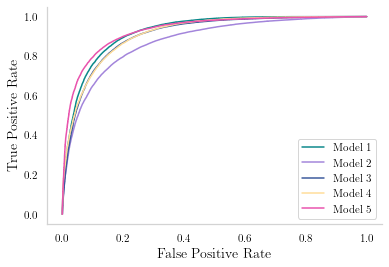

<Figure size 432x288 with 0 Axes>

In [27]:
model_names = ['avid-grass-133', 'floral-valley-132', 'stellar-fog-131', 'wise-firefly-130', 'silver-blaze-129']
colours = [cd['green'],cd['lightpurple'], '#3b599c', cd['yellow'], cd['pink']]
data[0].keys()

plt.figure()
for i, d in enumerate(data):
    true_labels = d['true_labels']
    model_probabilities = d['predicted_probs']
    predicted_classes = d['predicted_classes']
    predicted_probs = [model_probabilities[i][1] for i in range(len(model_probabilities))]
    
    #AUC
    auc_score = roc_auc_score(true_labels, predicted_probs)
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    ns_probs = [0 for _ in range(len(true_labels))]
    plt.plot(fpr, tpr, color=colours[i], label=f"Model {i+1}")
    
# ns_fpr, ns_tpr, _ = roc_curve(true_labels, ns_probs)
# plt.plot(ns_fpr, ns_tpr, color=cd['green'], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
# plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + "cv1_roc" + ".eps", format="eps", bbox_inches='tight')   
    

364585
364585


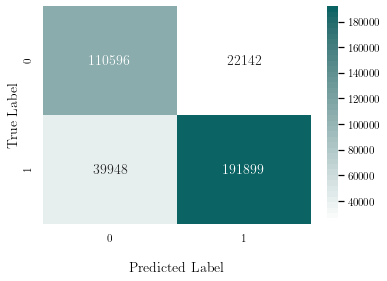

In [42]:
plt.figure()
all_true = []
all_predicted = []
for i, d in enumerate(data):
    true_labels = d['true_labels']
    model_probabilities = d['predicted_probs']
    predicted_classes = d['predicted_classes']
    all_true.extend(true_labels)
    all_predicted.extend(predicted_classes)

print(len(all_true))
print(len(all_predicted))
#CM
cm = confusion_matrix(all_true, all_predicted)
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap=custom_grn)
# plt.title('Confusion Matrix');
plt.xlabel('\nPredicted Label')
plt.ylabel('True Label')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='plasma', values_format='.0f')
# disp.plot(cmap='PuBuGn', values_format='.2%')
# plt.show()
plt.savefig("/home/21576262@su/masters/reports/data figs/final/cv1_cm.eps", format="eps", bbox_inches='tight')   

In [28]:
metrics = get_metrics(true_labels, model_probabilities)
print(metrics)

              precision    recall  f1-score   support

           0       0.89      0.52      0.66     19609
           1       0.74      0.95      0.83     28100

    accuracy                           0.78     47709
   macro avg       0.82      0.74      0.75     47709
weighted avg       0.80      0.78      0.76     47709



ROC AUC=1.000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


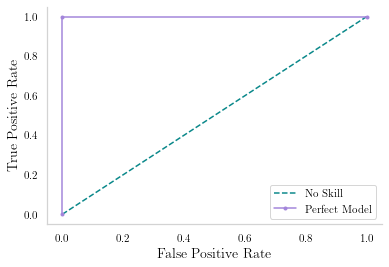

In [52]:
roc_plot(true_labels, true_labels)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


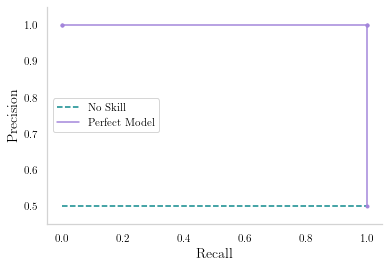

In [53]:
plot_pr_curve(true_labels, true_labels)

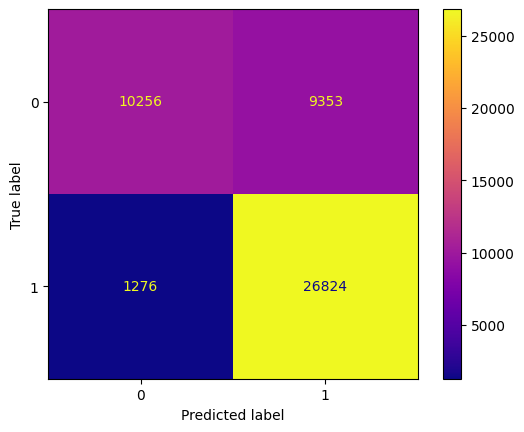

In [84]:
plot_confusion_matrix(true_labels, model_predictions)

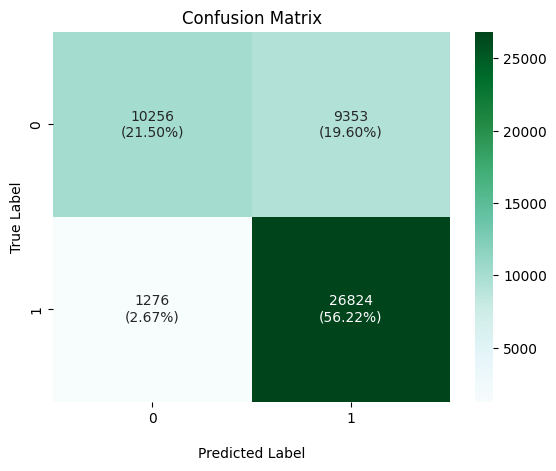

In [123]:
plot_confusion_matrix(true_labels, model_predictions)

### Load model

In [ ]:
# TESTING SIMPLE CNN MODEL
model_path = '../models/splendid-dawn-22_model_weights.pth'

model = load_trained_model(num_classes, model_path)

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model = model.to(device)

In [ ]:
accuracy = test_model(dataloaders['test'])

Notes:
- need to test on independent data (Yale)
- check method on a slide that does not contain any malignant tissue and test performance

In [ ]:
run_name = os.path.splittext(os.path.basename(model_path))[0].split('_')[0]
print(run_name)

In [ ]:
# wandb.init(project='masters', id='wxe3pjwt') ## THIS OVERRIDES PREVIOUS METRICS -- LOOK INTO, DON'T USE YET
# wandb.log({"Test Accuracy": accuracy})
# wandb.finish()

In [ ]:
from tqdm import tqdm
import os
import sys
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
import random
import torch.utils.data as data_utils
from PIL import Image
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

def load_trained_model(num_classes, model_path): 

    # # INCEPTION
    # # Define model architecture
    # model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
    # # Replace last layers with new layers
    # num_ftrs = model.fc.in_features
    # model.fc = nn.Sequential(
    #     nn.Linear(num_ftrs, 2048),
    #     nn.ReLU(inplace=True),
    #     nn.Dropout(p=0.7),
    #     nn.Linear(2048, num_classes),
    #     nn.Softmax(dim=1)
    # )
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(64 * 32 * 32, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes),
    )

    # Load the saved model state dict
    model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    model.eval()

    return model

def test_model(model, test_loader, device):
    
    correct = 0
    total = 0
    
    # Create a progress bar
    progress_bar = tqdm(test_loader, desc='Testing', unit='batch')

    with torch.no_grad():
        true_labels = []
        predictions = []
        probabilities = []
        for inputs, labels in progress_bar:
            # move to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.extend(labels.tolist())

            # Forward pass
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update variables
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probabilities.extend(probs.tolist())
            predictions.extend(predicted.tolist())

            # Update progress bar description
            progress_bar.set_postfix({'Accuracy': '{:.2f}%'.format((correct / total) * 100)})
    
    # # Compute accuracy (testing for now) --delete
    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))
    # Close the progress bar
    progress_bar.close()
    
    return true_labels, probabilities, predictions

# Split image folders into train, val, test
def split_data(patch_directory, split: list, seed):
    '''
    Function that takes in the split percentage for train/val/test sets, and randomly chooses which cases
    to allocate to which set (to ensure all patches from one case go into one set)
    Parameters:
    patch_directory: folder containing all patches
    split: list of integers for splitting sets
    seed: option to set the seed value for randomness
    Returns:
    3 lists for each of train/val/test, where each list contains the case names to be used in the set
    '''
    
    random.seed(seed)

    case_folders = os.listdir(patch_directory) # get 147 case folders
    
    d = {}
    for folder in case_folders:
        num_patches_in_folder = len(os.listdir(patch_directory + folder))
        d[folder] = num_patches_in_folder
    
    total_num_patches = sum(d.values())
    train_split, val_split, test_split = split
    train_num_patches = int((train_split/100)*total_num_patches)
    val_num_patches = int((val_split/100)*total_num_patches)

    # list all folders in the directory
    folders = [os.path.join(patch_directory, folder) for folder in os.listdir(patch_directory) if os.path.isdir(os.path.join(patch_directory, folder))]
    
    # SELECT TRAINING CASES
    train_cases = [] # store all selected cases
    num_selected_train = 0 # number of patches selected so far
    selected_folders = set() # a set to store the selected folder names to keep track of those already selected
    while num_selected_train < train_num_patches:
        folder = random.choice(folders)
        if folder not in selected_folders:
            case = folder.replace(patch_directory, '')
            num_patches = len(os.listdir(folder))
            num_selected_train += num_patches
            selected_folders.add(folder) # add to set of selected folders
            train_cases.append(case)

    # SELECT VAL CASES
    val_cases = [] # store all selected cases
    num_selected_val = 0 # number of patches selected so far
    while num_selected_val < val_num_patches:
        folder = random.choice(folders)
        if folder not in selected_folders:
            case = folder.replace(patch_directory, '')
            num_patches = len(os.listdir(folder))
            num_selected_val += num_patches
            selected_folders.add(folder)
            val_cases.append(case)

    # SELECT TEST CASES
    cases = [folder.replace(patch_directory, '') for folder in folders]
    used = train_cases+val_cases
    test_cases = [case for case in cases if case not in used]
    
    # test_patches = [len(os.listdir(patch_directory + folder)) for folder in test_cases]
    num_selected_test = sum([len(os.listdir(patch_directory + folder)) for folder in test_cases])
    # dict = {x: for x in ['train', 'val', 'test']}
    print(f"Number of training patches: {num_selected_train} \nNumber of validation patches {num_selected_val} \nNumber of test patches {num_selected_test}")
    return train_cases, val_cases, test_cases

# Create a custom PyTorch dataset to read in your images and apply transforms

class CustomDataset(Dataset):
    def __init__(self, img_folders, label_files, transform=None):
        self.img_folders = img_folders
        self.label_files = label_files
        self.transform = transform

        self.imgs = [] # Keeps image paths to load in the __getitem__ method
        self.labels = []

        # Load images and corresponding labels
        for i, (img_folder, label_file) in enumerate(zip(img_folders, label_files)):
            # print("Patch directory", img_folder, "\nLabel file", label_file)
            labels_pt = torch.load(label_file) # Load .pt file
            # Run through all patches from the case folder
            for i, img in enumerate(os.listdir(img_folder)):
                if os.path.isfile(img_folder + '/' + img) and os.path.isfile(label_file):
                    # print(img_folder + img)
                    if img.startswith('._'):
                        img = img.replace('._', '')
                    idx = int(img.replace('.png', '').split("_")[1])
                    self.imgs.append(img_folder + '/' + img)
                    self.labels.append(labels_pt[idx].item()) # get label as int
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # Load image at given index
        image_path = self.imgs[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform is not None: # Apply transformations
            image = self.transform(image)
        
        label = self.labels[idx] # Load corresponding image label
        
        return image, label # Return transformed image and label
    
def load_data(INPUT_SIZE, SEED, batch_size, num_cpus):
    # DATALOADERS

    # Initialise data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test' : transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # using full set of data
    # img_dir = '../data/processed/patches/'
    # labels_dir = '../data/processed/labels/'
    img_dir = '/Volumes/AlexS/MastersData/processed/patches/'
    labels_dir = '/Volumes/AlexS/MastersData/processed/labels/'

    split=[70, 15, 15] # for splitting into train/val/test

    train_cases, val_cases, test_cases = split_data(img_dir, split, SEED)

    train_img_folders = [img_dir + case for case in train_cases]
    val_img_folders = [img_dir + case for case in val_cases]
    test_img_folders = [img_dir + case for case in test_cases]

    # Contains the file path for each .pt file for the cases used in each of the sets
    train_labels = [labels_dir + case + '.pt' for case in train_cases]
    val_labels = [labels_dir + case + '.pt' for case in val_cases]
    test_labels = [labels_dir + case + '.pt' for case in test_cases]

    image_datasets = {
        'train': CustomDataset(train_img_folders, train_labels, transform=data_transforms['train']),
        'val': CustomDataset(val_img_folders, val_labels, transform=data_transforms['val']),
        'test': CustomDataset(test_img_folders, test_labels, transform=data_transforms['test'])
    }
    # Create training, validation and test dataloaders
    dataloaders = {
        'train': data_utils.DataLoader(image_datasets['train'], batch_size=batch_size, num_workers=num_cpus, shuffle=True, drop_last=True),
        'val': data_utils.DataLoader(image_datasets['val'], batch_size=batch_size, num_workers=num_cpus, shuffle=True),
        'test': data_utils.DataLoader(image_datasets['test'], batch_size=batch_size, num_workers=num_cpus, shuffle=True)
    }

    return dataloaders

def roc_plot(y_test, predicted_probs):
    # keep probabilities for the positive outcome only
    print(len(predicted_probs))
    # predicted_probs = predicted_probs[:, 1]
    # calculate scores
    auc_score = roc_auc_score(y_test, predicted_probs)
    # summarize scores
    print('ROC AUC=%.3f' % (auc_score))
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_test, predicted_probs)
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def get_metrics(y_test, predictions):
    report = metrics.classification_report(y_test, predictions)
    return report

def plot_confusion_matrix(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [ ]:
##### SET PARAMETERS #####
num_classes = 2
batch_size = 64
model_name = 'None'

PATCH_SIZE=256
STRIDE=PATCH_SIZE
SEED=42
num_cpus=8

if model_name == 'inception': 
    INPUT_SIZE=299 
else: INPUT_SIZE=PATCH_SIZE

# Load data
dataloaders = load_data(INPUT_SIZE, SEED, batch_size, num_cpus)

# Load model
model_path = sys.argv[1]
model = load_trained_model(num_classes, model_path)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model = model.to(device)

true_labels, model_probabilities, model_predictions = test_model(model, dataloaders['test'], device)

Number of training patches: 256702 
Number of validation patches 55642 
Number of test patches 52242


FileNotFoundError: [Errno 2] No such file or directory: '--ip=127.0.0.1'

In [ ]:
metrics = get_metrics(true_labels, model_predictions)
print(metrics)

In [ ]:
roc_plot(true_labels, model_probabilities)

In [ ]:
plot_confusion_matrix(true_labels, model_probabilities)